In [47]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from scipy.io import loadmat
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import random
import copy
import numpy as np
import struct


### Uploading data

In [48]:
def load_idx3_ubyte(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images
def load_idx1_ubyte(file_path):
    with open(file_path, 'rb') as f:
        magic, num_items = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


In [49]:
train_images_path = '/Users/barryalphaoumar/Downloads/deep_learning_project/data/train-images.idx3-ubyte'
test_images_path = '/Users/barryalphaoumar/Downloads/deep_learning_project/data/t10k-images.idx3-ubyte'
train_labels_path = '/Users/barryalphaoumar/Downloads/deep_learning_project/data/train-labels.idx1-ubyte'
test_labels_path = '/Users/barryalphaoumar/Downloads/deep_learning_project/data/t10k-labels.idx1-ubyte'

#########

X_mnist_train = load_idx3_ubyte(train_images_path)
X_mnist_test = load_idx3_ubyte(test_images_path)
y_mnist_train = load_idx1_ubyte(train_labels_path)
y_mnist_test = load_idx1_ubyte(test_labels_path)

binary_alpha_digits = loadmat('/Users/barryalphaoumar/Downloads/deep_learning_project/data/binaryalphadigs.mat')

In [56]:
def lire_alpha_digit(data,L):
    X=data['dat'][L[0]]
    for i in range(1,len(L)) :
        X_bis=data['dat'][L[i]]
        X=np.concatenate((X,X_bis),axis=0)
    n=X.shape[0]
    X=np.concatenate(X).reshape((n,320))
    return X

def display_images(images, size):
    for image in images:
        image = image.reshape(size)
        plt.imshow(image, cmap='gray')
        plt.show()

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [64]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class RBM:
    def __init__(self, p, q):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.random.normal(size=(p, q)) * np.sqrt(0.01)

    def init_RBM(self):
        # Initialisation des poids et biais
        self.a = np.zeros(self.W.shape[0])
        self.b = np.zeros(self.W.shape[1])
        self.W = np.random.normal(size=self.W.shape) * np.sqrt(0.01)

    def entree_sortie_RBM(self, V):
        # Calcul des sorties
        return sigmoid(V @ self.W + self.b)

    def sortie_entree_RBM(self, H):
        # Calcul des entrées
        return sigmoid(H @ self.W.T + self.a)

    def train_RBM(self, X, learning_rate, len_batch, n_epochs, verbose=False):
        weights = []
        losses = []

        for i in range(n_epochs):
            np.random.shuffle(X)
            n = X.shape[0]
            for i_batch in range(0, n, len_batch):
                X_batch = X[i_batch:min(i_batch + len_batch, n), :]
                t_batch_i = X_batch.shape[0]

                V0 = copy.deepcopy(X_batch)
                pH_V0 = self.entree_sortie_RBM(V0)
                H0 = (np.random.rand(t_batch_i, self.W.shape[1]) < pH_V0) * 1
                pV_H0 = self.sortie_entree_RBM(H0)
                V1 = (np.random.rand(t_batch_i, self.W.shape[0]) < pV_H0) * 1
                pH_V1 = self.entree_sortie_RBM(V1)

                da = np.sum(V0 - V1, axis=0)
                db = np.sum(pH_V0 - pH_V1, axis=0)
                dW = V0.T @ pH_V0 - V1.T @ pH_V1

                self.a += learning_rate * da
                self.b += learning_rate * db
                self.W += learning_rate * dW

                weights.append(np.mean(self.W))

            H = self.entree_sortie_RBM(X)
            X_rec = self.sortie_entree_RBM(H)
            loss = np.mean((X - X_rec) ** 2)
            losses.append(loss)
            if i % 10 == 0 and verbose:
                print("epoch " + str(i) + "/" + str(n_epochs) + " - loss : " + str(loss))

        plt.plot(losses)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Evolution of the loss through ' + str(n_epochs) + ' epochs')
        plt.show()
        print("Final loss:", losses[-1])

        plt.xlabel('epochs')
        plt.ylabel('mean elements of weight W')
        plt.plot(weights)
        plt.show()

    def generer_image_RBM(self, nb_images, nb_iter, size_img):
        images = []
        for i in range(nb_images):
            v = (np.random.rand(self.W.shape[0]) < 0.5) * 1
            for j in range(nb_iter):
                h = (np.random.rand(self.W.shape[1]) < self.entree_sortie_RBM(v)) * 1
                v = (np.random.rand(self.W.shape[0]) < self.sortie_entree_RBM(h)) * 1
            v = v.reshape(size_img)
            images.append(v)
        return images

In [65]:
size_img = binary_alpha_digits['dat'][0][0].shape
X = lire_alpha_digit(binary_alpha_digits, [10, 11])
X.shape

(78, 320)

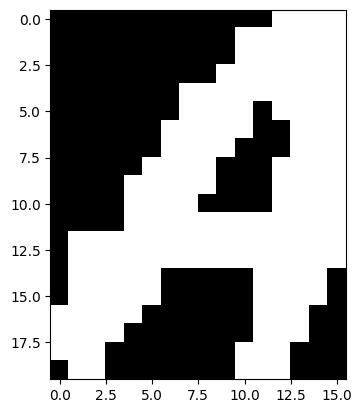

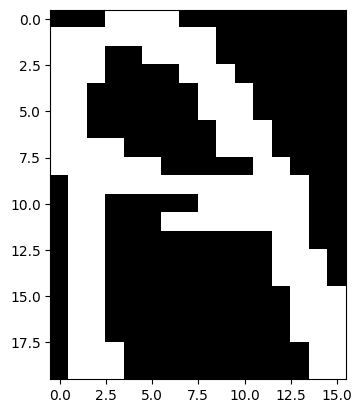

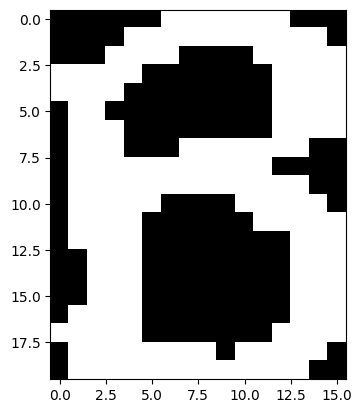

In [66]:
for _ in range(3):
    i = np.random.choice(X.shape[0])
    display_images([X[i]], size_img)

In [67]:
p = size_img[0]*size_img[1]
q = 100
rbm = RBM(p,q)

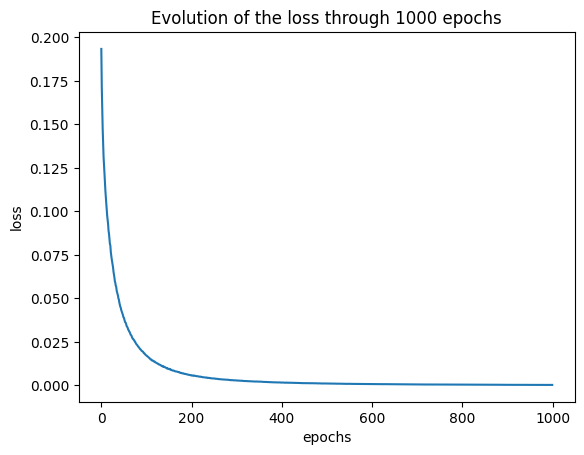

Final loss: 0.00029295235354307364


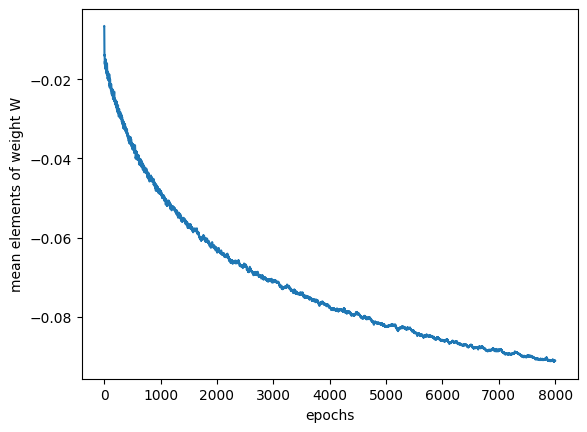

In [69]:
rbm.train_RBM(X, learning_rate=10**(-2), len_batch=10, n_epochs=1000, verbose=False)

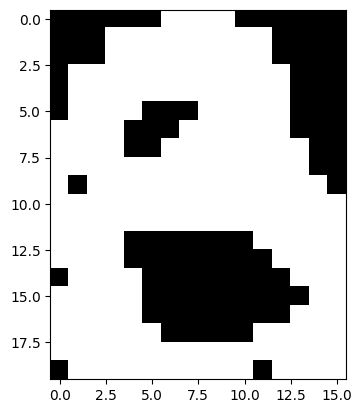

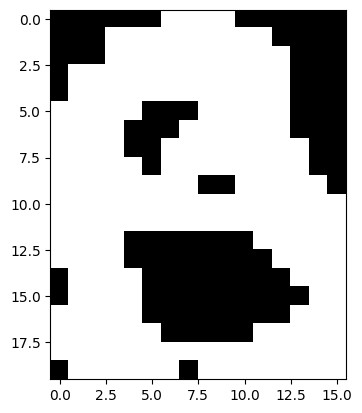

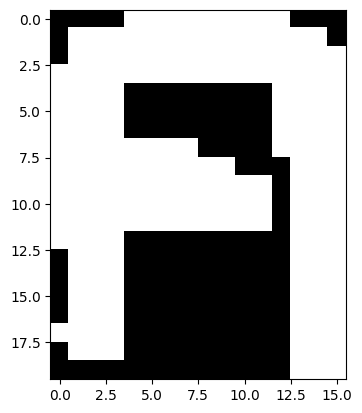

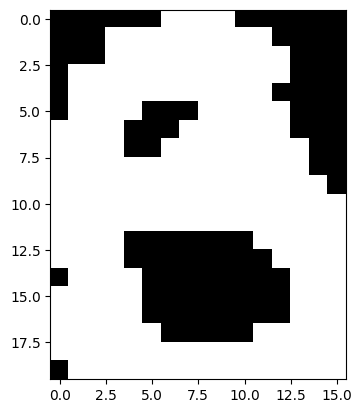

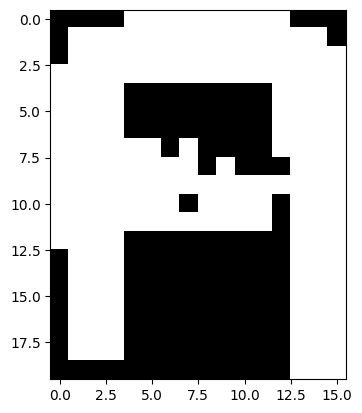

In [71]:
images = rbm.generer_image_RBM(nb_images=5, nb_iter=200, size_img=size_img)
display_images(images, size_img)